# Evaluating GradCAM (base)

## Imports and Setup

In [1]:
import os
import platform
from pathlib import Path

# for when on NCC to be able to import local packages
os.chdir(os.path.expanduser("~/l3_project"))
Path.cwd()

PosixPath('/home2/jgcw74/l3_project')

In [119]:
import importlib

import helpers
import dataset_processing.eurosat

# to reload local module changes without kernel restart
importlib.reload(helpers.evaluate_xai)

<module 'helpers.evaluate_xai' from '/home2/jgcw74/l3_project/helpers/evaluate_xai.py'>

In [117]:
import copy

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import numpy as np
import matplotlib.pyplot as plt
import einops

import torch
import torch.nn as nn

from safetensors.torch import load_model

In [5]:
print(f'Using PyTorch {torch.__version__} on {platform.system()}')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Found {torch.cuda.get_device_name()} to use as a cuda device.')
elif platform.system() == 'Darwin':
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} as torch device.')

if platform.system() != 'Linux':
    torch.set_num_threads(1)  # significantly speeds up data loading processes with less loading overhead
    # see https://discuss.pytorch.org/t/pytorch-v2-high-cpu-consumption/205990 and https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228
    print('Set number of threads to 1 as using a non-Linux machine.')

Using PyTorch 2.5.1 on Linux
Found NVIDIA A100 80GB PCIe to use as a cuda device.
Using cuda as torch device.


In [6]:
np_rng = np.random.default_rng(42)
_ = torch.manual_seed(42)

# EuroSAT (RGB) Dataset

In [8]:
eurosat_val_ds = dataset_processing.eurosat.get_standard_rgb("val")

num_eurosat_classes = len(eurosat_val_ds.classes)

print(f"There are {len(eurosat_val_ds)} validation samples.")
print("Image dimensions and label:", eurosat_val_ds[0]["image"].size(), eurosat_val_ds[0]["label"])

There are 5400 validation samples.
Image dimensions and label: torch.Size([3, 224, 224]) tensor(0)


In [9]:
val_dataloader = torch.utils.data.DataLoader(
    eurosat_val_ds, batch_size=32, num_workers=4, shuffle=False, drop_last=False
)
validation_iterator = iter(dataset_processing.core.cycle(val_dataloader))

## ResNet 50

### Load Model

In [10]:
checkpoints_path = Path.cwd() / 'checkpoints'
assert checkpoints_path.exists()

In [11]:
all_resnet50_saved = list(checkpoints_path.glob('./resnet50/*.st'))
# print(all_resnet50_saved)
latest_resnet50_path = max(all_resnet50_saved, key=os.path.getctime)
latest_resnet50_path

PosixPath('/home2/jgcw74/l3_project/checkpoints/resnet50/FineTunedResNet50_final_ft_weights(0.989).st')

In [12]:
resnet50 = helpers.models.FineTunedResNet50(num_classes=num_eurosat_classes).to(device)

In [13]:
print('Missing/Unexpected keys:', load_model(resnet50, latest_resnet50_path))
_ = resnet50.eval()

Missing/Unexpected keys: (set(), [])


#### Confirm model accuracy

In [14]:
check_acc = False
if check_acc:
    _, acc = helpers.ml.validation_step(
        resnet50, nn.CrossEntropyLoss(), validation_iterator, len(val_dataloader)
    )
    assert acc > 0.98
    print("Validation accuracy", acc)

### Select images to explain

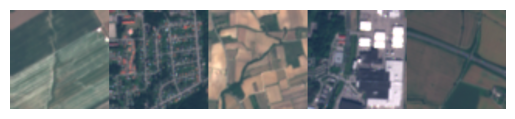

In [15]:
idxs_to_explain = np_rng.integers(0, len(eurosat_val_ds), 5)
imgs_to_explain = torch.stack([eurosat_val_ds[i]["image"] for i in idxs_to_explain]).to(device)
true_labels = [eurosat_val_ds[i]["label"] for i in idxs_to_explain]
helpers.plotting.show_image(
    einops.rearrange(imgs_to_explain, "(b1 b2) c h w -> c (b1 h) (b2 w)", b2=len(idxs_to_explain)))

[tensor(0), tensor(7), tensor(6), tensor(4), tensor(3)]


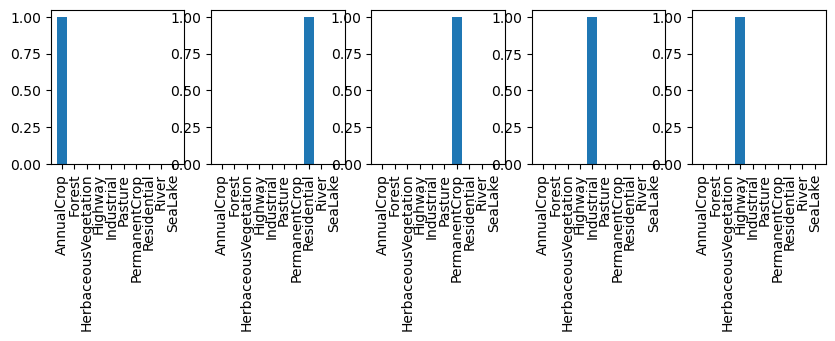

In [16]:
preds = resnet50(imgs_to_explain)
preds = torch.softmax(preds, dim=-1).cpu().detach().numpy()
_, axs = plt.subplots(1, len(idxs_to_explain), figsize=(2 * len(idxs_to_explain), 2))
for i in range(len(idxs_to_explain)):
    ax: plt.Axes = axs[i]
    ax.bar(eurosat_val_ds.classes, preds[i])
    # rotate x ticks for axis
    ax.tick_params(axis='x', rotation=90)
print(true_labels)

### Set up/Experiment with GradCAM

In [55]:
# target the last layer of the model before avg and fc
gradcam_explainer = GradCAM(resnet50, target_layers=[resnet50.model.layer4[-1]])

In [59]:
cam_output = gradcam_explainer(
    input_tensor=imgs_to_explain,
    aug_smooth=False, eigen_smooth=False,
    targets=None
)

In [60]:
ranked_cam = helpers.evaluate_xai.rank_pixel_importance(cam_output[:, :, :, np.newaxis])  # add fake colour channel

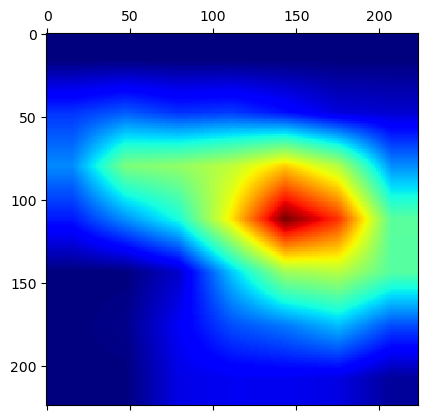

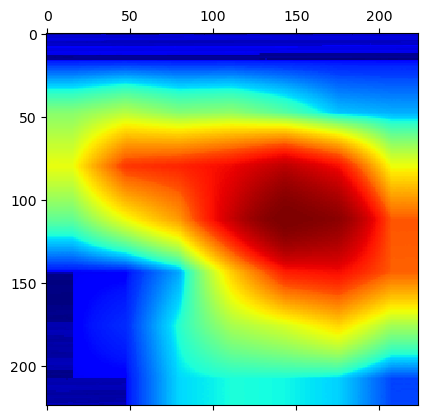

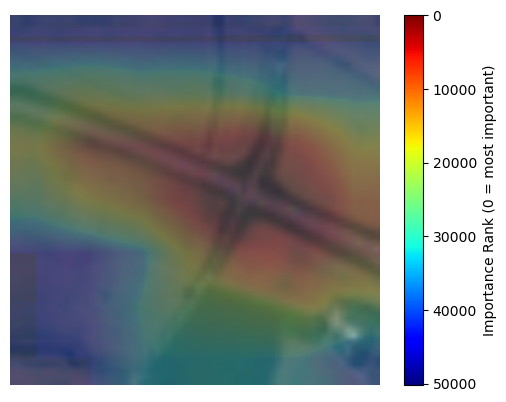

In [70]:
i = 4
true_label_text = eurosat_val_ds.classes[int(true_labels[i])]
plt.matshow(cam_output[i], cmap="jet")
plt.show()
plt.matshow(ranked_cam[i], cmap="jet_r")
plt.show()
helpers.plotting.visualise_importance(imgs_to_explain[i], ranked_cam[i])

### Model Parameter Randomisation

In [123]:
randomised_model = copy.deepcopy(resnet50).to(device)
helpers.evaluate_xai.reset_child_params(randomised_model)
_ = randomised_model.eval()

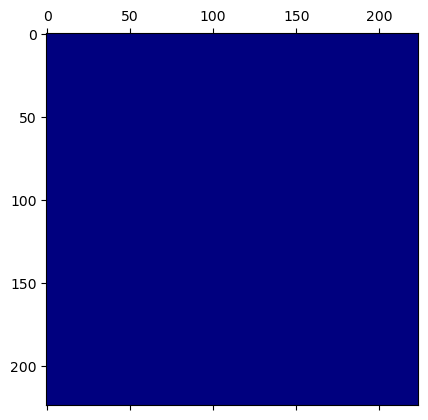

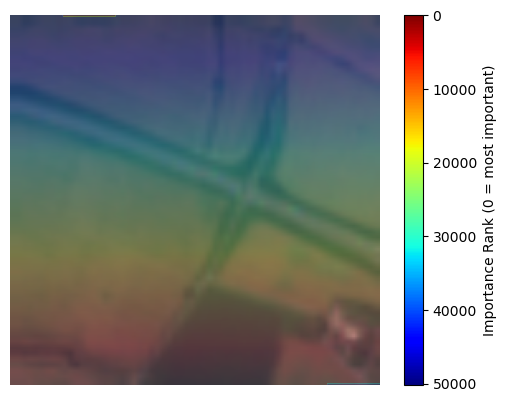

In [127]:
# target the last layer of the model before avg and fc
gradcam_random_explainer = GradCAM(randomised_model, target_layers=[randomised_model.model.layer4[-1]])
cam_random_output = gradcam_random_explainer(
    input_tensor=imgs_to_explain,
    aug_smooth=False, eigen_smooth=False,
    targets=[ClassifierOutputTarget(int(true_labels[i]))]  # since the randomised model isn't going to be accurate
)
ranked_random_cam = helpers.evaluate_xai.rank_pixel_importance(
    cam_random_output[:, :, :, np.newaxis])  # add fake colour channel
plt.matshow(cam_random_output[i], cmap="jet")
plt.show()
helpers.plotting.visualise_importance(imgs_to_explain[i], ranked_random_cam[i])

### Incremental Deletion

##### By importance

Incrementally deleting important pixels:   0%|          | 0/31 [00:00<?, ?it/s]

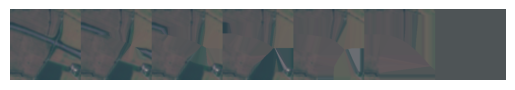

In [89]:
num_del_iterations = 30
iterative_deletions, k_values = helpers.evaluate_xai.incrementally_delete(imgs_to_explain[i].cpu().numpy(),
                                                                          ranked_cam[i],
                                                                          num_del_iterations,
                                                                          "nn")  # Nearest neighbour deletion as in I. Kakogeorgiou and K. Karantzalos
iterative_deletions = np.squeeze(iterative_deletions)  # remove singleton dim (no repeats for specified importance)
helpers.plotting.show_image(einops.rearrange(iterative_deletions[::5], "p c h w -> c h (p w)"))
plt.show()

In [90]:
df = helpers.evaluate_xai.make_preds_df(resnet50, iterative_deletions, columns=eurosat_val_ds.classes)

##### Random

In [107]:
num_rand_trials = 10
random_deletions, k_values = helpers.evaluate_xai.incrementally_delete(imgs_to_explain[i].cpu().numpy(),
                                                                       (16, None, num_rand_trials),
                                                                       num_del_iterations, "nn")

Incrementally deleting important pixels:   0%|          | 0/31 [00:00<?, ?it/s]

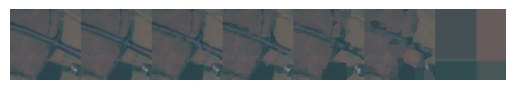

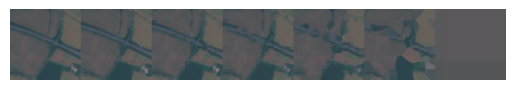

In [108]:
helpers.plotting.show_image(einops.rearrange(random_deletions[::5, 0], "p c h w -> c h (p w)"))
plt.show()
helpers.plotting.show_image(einops.rearrange(random_deletions[::5, 1], "p c h w -> c h (p w)"))
plt.show()

In [116]:
flatted_random_deletions = random_deletions.reshape(-1, *random_deletions.shape[2:])  # combine iterations and trials
flatted_random_deletions

array([[[[-0.42981815, -0.42981815, -0.42981815, ..., -0.37563664,
          -0.39854544, -0.39854544],
         [-0.42981815, -0.42981815, -0.42981815, ..., -0.37563664,
          -0.39854544, -0.39854544],
         [-0.42981815, -0.42981815, -0.42981815, ..., -0.37563664,
          -0.39854544, -0.39854544],
         ...,
         [-0.19896112, -0.19896112, -0.19896112, ..., -0.41174027,
          -0.41890904, -0.41890904],
         [-0.20581818, -0.20581818, -0.20581818, ..., -0.4076884 ,
          -0.41672724, -0.41672724],
         [-0.20581818, -0.20581818, -0.20581818, ..., -0.4076884 ,
          -0.41672724, -0.41672724]],

        [[-0.3396364 , -0.3396364 , -0.3396364 , ..., -0.30187032,
          -0.31636363, -0.31636363],
         [-0.3396364 , -0.3396364 , -0.3396364 , ..., -0.30187032,
          -0.31636363, -0.31636363],
         [-0.3396364 , -0.3396364 , -0.3396364 , ..., -0.30187032,
          -0.31636363, -0.31636363],
         ...,
         [-0.24316888, -0.24316888

In [115]:
rand_df = helpers.evaluate_xai.make_preds_df(resnet50, flatted_random_deletions, columns=eurosat_val_ds.classes)
# group every num_rand_trials rows together to get the average
rand_df = rand_df.groupby(np.arange(len(rand_df)) // num_rand_trials).mean()
rand_df

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
0,1.453617e-10,6.315378e-14,2.477576e-14,9.999847e-01,2.295276e-10,1.529828e-05,6.344391e-10,1.094809e-12,5.361472e-09,5.608778e-11
1,3.070807e-10,1.484926e-12,2.447143e-13,9.998382e-01,1.115787e-09,1.617071e-04,3.811487e-09,1.321806e-11,2.063684e-08,1.533374e-10
2,6.708699e-10,1.360427e-11,1.023539e-12,9.993551e-01,6.246409e-09,6.447576e-04,3.597646e-08,2.730091e-11,2.353057e-08,1.780437e-10
3,6.411311e-10,1.466769e-11,2.109381e-12,9.990609e-01,4.968023e-09,9.388238e-04,2.213379e-08,8.727012e-11,2.468288e-07,3.578414e-10
4,1.360527e-09,2.174062e-10,1.022590e-11,9.863472e-01,3.008193e-08,1.365085e-02,5.819080e-07,3.543432e-10,1.367322e-06,1.754624e-09
5,3.212865e-09,4.309270e-10,3.922475e-11,9.851694e-01,4.010817e-08,1.482819e-02,1.580209e-06,3.331543e-09,7.453160e-07,2.421299e-09
6,7.641091e-10,6.385087e-09,1.325497e-10,9.800345e-01,7.089952e-08,1.996013e-02,2.298857e-06,7.358694e-09,3.085953e-06,4.435794e-09
7,2.295652e-08,4.948844e-08,1.471836e-10,8.936583e-01,8.638476e-08,1.062717e-01,5.714941e-05,6.761309e-08,1.256002e-05,9.142028e-08
8,2.552683e-09,7.606675e-08,1.477913e-09,8.990649e-01,6.206843e-08,1.008173e-01,8.072575e-05,1.964199e-08,3.687386e-05,2.381001e-08
9,1.208684e-09,1.067394e-07,2.358664e-09,8.832371e-01,4.047385e-08,1.167146e-01,3.992544e-05,2.748949e-07,7.869538e-06,1.098626e-08


<Axes: title={'center': 'Effect of random deletions on correct class prediction confidence'}, xlabel='iterations', ylabel='confidence'>

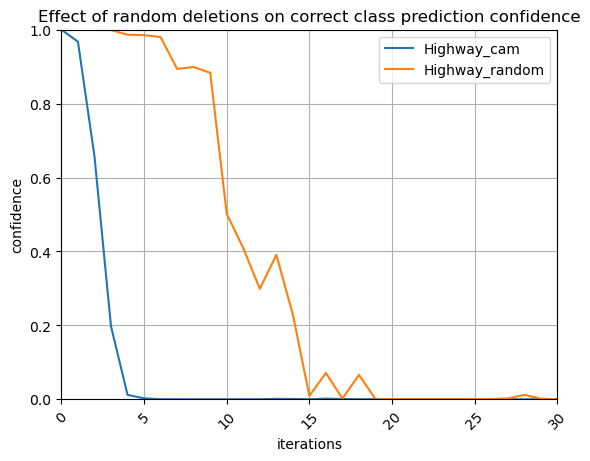

In [114]:
joined_df = df.join(rand_df, lsuffix="_cam", rsuffix="_random")
joined_df.plot(kind="line", xlabel="iterations", rot=45, xlim=(0, num_del_iterations),
               y=[f"{true_label_text}_cam", f"{true_label_text}_random"],
               ylabel="confidence", ylim=(0, 1),
               grid=True,
               title="Effect of random deletions on correct class prediction confidence")

In [112]:
np.trapz(df[true_label_text].to_numpy()), np.trapz(rand_df[true_label_text].to_numpy())

(2.342438, 11.12206)